# 2025年 世界モデル コンペティション1 ベースライン
**最低限の要件**  
- 行動を出力する agent は引数として obs (numpy.ndarray) を受け取り，action (float) と prior を用いた観測の再構成画像 (numpy.ndarray) を返すように実装する．
- 評価時に行動を出力する際には `agent(obs)` と実装している．他の引数を定義しても問題ないが，評価時には他の引数を指定できないため，デフォルトの設定で評価モードにしておく必要がある．

**書き換え可能箇所**  
- 準備: 必要なライブラリの追加．ただし提出ファイルの作成に google drive を参照するためマウントは削除しないでください．
- モデルの実装・学習: 利用したいアルゴリズム及びモデルに自由に変更して構いません．ただしエージェントの入出力の形式は要件を満たしてください．

**書き換えてはいけない箇所**  
- 環境の設定: omnicampus 上の採点で利用する環境のため，修正しないでください．
- 補助機能の実装: エージェントが要件を満たしているか検証する関数になっています．


## 目次
### モデルの学習と保存
1. [準備]()
2. [環境の設定]()
3. [補助機能の実装]()
4. [モデルの実装]()
5. [モデルの学習]()
6. [エージェントの保存]()
7. [student_code.py の作成]()

### 提出物の作成
8. [submission_tool の準備]()
9. [提出物の作成]()
10. [提出内容のプレビュー]()

## 1. 準備

必要なライブラリのインストール．各自必要なライブラリがある場合は追加でインストールしてください．  

In [1]:
# ライブラリインストール
!pip install metaworld pyvirtualdisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 3.2 MB/s eta 0:00:00


In [2]:
# colab / ubuntu用
# 仮想ディスプレイの設定（レンダリング用）
!apt install -y xvfb > /dev/null 2>&1

In [3]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(400, 300))
virtual_display.start()

In [4]:
import time
import os
import gc
import random
from typing import Any, List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import gym
from gym.wrappers import ResizeObservation
import metaworld
from metaworld.env_dict import (
    ALL_V3_ENVIRONMENTS_GOAL_OBSERVABLE,
    ALL_V3_ENVIRONMENTS_GOAL_HIDDEN,
)
import torch
import torch.distributions as td
from torch.distributions import Normal, OneHotCategoricalStraightThrough
from torch.distributions.kl import kl_divergence
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

## 2. 環境の設定  
**環境の設定については修正しないでください**  
- こちらで実装している環境を用いてOmnicampus上では評価を行います．  

In [5]:
class GymWrapperMetaWorld(object):
    """
    MetaWorld環境のためのラッパー
    """

    metadata = {"render.modes": ["human", "rgb_array"]}
    reward_range = (-np.inf, np.inf)

    # __init__でカメラ位置に関するパラメータ（ cam_dist:カメラ距離，cam_yaw：カメラの水平面での回転，cam_pitch:カメラの縦方向での回転）を受け取り，カメラの位置を調整できるようにします.
    # 　同時に画像の大きさも変更できるようにします
    def __init__(
        self,
        name,
        seed=None,
        size=(64, 64)
    ) -> None:
        # os.environ["MUJOCO_GL"] = "egl"
        os.environ["MUJOCO_GL"] = "glfw"

        task = f"{name}-v3-goal-observable"
        env_cls = ALL_V3_ENVIRONMENTS_GOAL_OBSERVABLE[task]
        self._env = env_cls(seed=seed, render_mode="rgb_array")
        self._env.mujoco_renderer.camera_id = 1  # corner に相当
        self._env.mujoco_renderer.camera_name = None
        self._size = size

    def __getattr(self, name: str) -> Any:
        return getattr(self._env, name)

    @property
    def observation_space(self) -> gym.spaces.Box:
        width, height = self._size
        return gym.spaces.Box(0, 255, (height, width, 3), dtype=np.uint8)

    @property
    def action_space(self) -> gym.spaces.Box:
        return self._env.action_space

    # 　元の観測（低次元の状態）は今回は捨てて，env.render()で取得した画像を観測とします.
    #  画像，報酬，終了シグナルが得られます.
    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):
        _, reward, done, truncated, info = self._env.step(action)
        obs = self._env.mujoco_renderer.render(render_mode="rgb_array")
        obs = np.flipud(obs)
        return obs, reward, done, truncated, info

    def reset(self) -> np.ndarray:
        self._env.reset()
        obs = self._env.mujoco_renderer.render(render_mode="rgb_array")
        obs = np.flipud(obs)
        return obs

    def close(self) -> None:
        self._env.close()

In [6]:
class RepeatAction(gym.Wrapper):
    """
    同じ行動を指定された回数自動的に繰り返すラッパー. 観測は最後の行動に対応するものになる
    """
    def __init__(self, env, skip=4, max_steps=100_000):
        gym.Wrapper.__init__(self, env)
        self.max_steps = max_steps if max_steps else float("inf")  # イテレーションの制限
        self.steps = 0  # イテレーション回数のカウント
        self.height = env.observation_space.shape[0]
        self.width = env.observation_space.shape[1]
        self._skip = skip

    def reset(self):
        obs = self.env.reset()
        return obs

    def step(self, action):
        if self.steps >= self.max_steps:
            print("Reached max iterations.")
            return None

        total_reward = 0.0
        self.steps += 1
        for _ in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)

            total_reward += reward
            if self.steps >= self.max_steps:
                done = True

            if done or truncated:
                break

        return obs, total_reward, done, truncated, info

In [7]:
def make_env(env, seed=None, img_size=64, max_steps=None):
    # シード固定
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    env = ResizeObservation(env, (img_size, img_size))
    env = RepeatAction(env=env, skip=1, max_steps=max_steps)

    return env

In [8]:
env = GymWrapperMetaWorld("hammer", seed=0, size=(64, 64))
env = make_env(env, seed=0)

/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


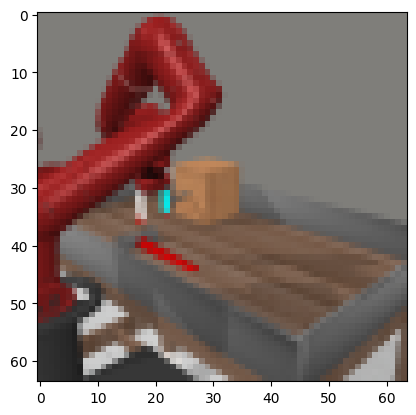

In [9]:
obs = env.reset()
plt.imshow(obs)

## 3. 補助機能の実装  
- set_seed: torchのシード値を固定できる関数です．   
- check_output_type: エージェントが要件を満たしているか検証する関数です．

In [10]:
def set_seed(seed: int) -> None:
    """
    Pytorch, NumPyのシード値を固定します．これによりモデル学習の再現性を担保できます．

    Parameters
    ----------
    seed : int
        シード値．
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [11]:
def check_output_type(agent, env):
    """
    agent の入出力が要件を満たしているか検証する関数．
    agent は入力として環境からの観測をそのまま受取，環境に直接渡せる形式で出力を作成する必要がある．
    （テストケースも兼ねており，この関数で動作すれば採点環境でも動作する想定）
    """
    action_dim = env.action_space.shape[0]
    obs = env.reset()
    action, pred_obs = agent(obs)

    # int 型 + 行動次元に収まっているか確認
    assert action.shape[0] == action_dim and (np.abs(action) <= 1).all(), "行動の出力形式を満たしていません．(shape (4, ), -1 <= action <= 1)"
    assert pred_obs.shape[2] == 3 and (pred_obs >= 0).all() and (pred_obs <= 1).all(), "観測の出力形式を満たしていません．(shape (64, 64, 3), 0 <= obs <= 1)"
    _, reward, done, _, _ = env.step(action)

    print("要件を満たしています．")

## 4. モデルの実装
**モデルの実装は他のアルゴリズム・モデルに変更していただいて構いません**  








In [45]:
class MSE(td.Normal):
    def __init__(self, loc, validate_args=None):
        super(MSE, self).__init__(loc, 1.0, validate_args=validate_args)

    @property
    def mode(self):
        return self.mean

    def sample(self, sample_shape=torch.Size()):
        return self.rsample(sample_shape)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        # NOTE: dropped the constant term
        return -((value - self.loc) ** 2) / 2

# From https://github.com/toshas/torch_truncnorm/blob/main/TruncatedNormal.py
import math
from numbers import Number

import torch
from torch.distributions import Distribution, constraints
from torch.distributions.utils import broadcast_all

CONST_SQRT_2 = math.sqrt(2)
CONST_INV_SQRT_2PI = 1 / math.sqrt(2 * math.pi)
CONST_INV_SQRT_2 = 1 / math.sqrt(2)
CONST_LOG_INV_SQRT_2PI = math.log(CONST_INV_SQRT_2PI)
CONST_LOG_SQRT_2PI_E = 0.5 * math.log(2 * math.pi * math.e)


class TruncatedStandardNormal(Distribution):
    """
    Truncated Standard Normal distribution
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    arg_constraints = {
        'a': constraints.real,
        'b': constraints.real,
    }
    has_rsample = True

    def __init__(self, a, b, validate_args=None):
        self.a, self.b = broadcast_all(a, b)
        if isinstance(a, Number) and isinstance(b, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.a.size()
        super(TruncatedStandardNormal, self).__init__(batch_shape, validate_args=validate_args)
        if self.a.dtype != self.b.dtype:
            raise ValueError('Truncation bounds types are different')
        if any((self.a >= self.b).view(-1, ).tolist()):
            raise ValueError('Incorrect truncation range')
        eps = torch.finfo(self.a.dtype).eps
        self._dtype_min_gt_0 = eps
        self._dtype_max_lt_1 = 1 - eps
        self._little_phi_a = self._little_phi(self.a)
        self._little_phi_b = self._little_phi(self.b)
        self._big_phi_a = self._big_phi(self.a)
        self._big_phi_b = self._big_phi(self.b)
        self._Z = (self._big_phi_b - self._big_phi_a).clamp_min(eps)
        self._log_Z = self._Z.log()
        little_phi_coeff_a = torch.nan_to_num(self.a, nan=math.nan)
        little_phi_coeff_b = torch.nan_to_num(self.b, nan=math.nan)
        self._lpbb_m_lpaa_d_Z = (self._little_phi_b * little_phi_coeff_b -
                                 self._little_phi_a * little_phi_coeff_a) / self._Z
        self._mean = -(self._little_phi_b - self._little_phi_a) / self._Z
        # NOTE: additional to github.com/toshas/torch_truncnorm
        self._mode = torch.clamp(torch.zeros_like(self.a), self.a, self.b)
        self._variance = 1 - self._lpbb_m_lpaa_d_Z - ((self._little_phi_b - self._little_phi_a) / self._Z) ** 2
        self._entropy = CONST_LOG_SQRT_2PI_E + self._log_Z - 0.5 * self._lpbb_m_lpaa_d_Z

    @constraints.dependent_property
    def support(self):
        return constraints.interval(self.a, self.b)

    @property
    def mean(self):
        return self._mean

    @property
    def mode(self):
        return self._mode

    @property
    def variance(self):
        return self._variance

    def entropy(self):
        return self._entropy

    @property
    def auc(self):
        return self._Z

    @staticmethod
    def _little_phi(x):
        return (-(x ** 2) * 0.5).exp() * CONST_INV_SQRT_2PI

    @staticmethod
    def _big_phi(x):
        return 0.5 * (1 + (x * CONST_INV_SQRT_2).erf())

    @staticmethod
    def _inv_big_phi(x):
        return CONST_SQRT_2 * (2 * x - 1).erfinv()

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ((self._big_phi(value) - self._big_phi_a) / self._Z).clamp(0, 1)

    def icdf(self, value):
        return self._inv_big_phi(self._big_phi_a + value * self._Z)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return CONST_LOG_INV_SQRT_2PI - self._log_Z - (value ** 2) * 0.5

    def rsample(self, sample_shape=torch.Size()):
        # icdf is numerically unstable; as a consequence, so is rsample.
        shape = self._extended_shape(sample_shape)
        p = torch.empty(shape, device=self.a.device).uniform_(self._dtype_min_gt_0, self._dtype_max_lt_1)
        return self.icdf(p)


class TruncatedNormal(TruncatedStandardNormal):
    """
    Truncated Normal distribution
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    has_rsample = True

    def __init__(self, loc, scale, scalar_a, scalar_b, validate_args=None):
        self.loc, self.scale, a, b = broadcast_all(loc, scale, scalar_a, scalar_b)
        a = (a - self.loc) / self.scale
        b = (b - self.loc) / self.scale
        super(TruncatedNormal, self).__init__(a, b, validate_args=validate_args)
        self._log_scale = self.scale.log()
        self._mean = self._mean * self.scale + self.loc
        self._mode = torch.clamp(self.loc, scalar_a, scalar_b)  # NOTE: additional to github.com/toshas/torch_truncnorm
        self._variance = self._variance * self.scale ** 2
        self._entropy += self._log_scale

    def _to_std_rv(self, value):
        return (value - self.loc) / self.scale

    def _from_std_rv(self, value):
        return value * self.scale + self.loc

    def cdf(self, value):
        return super(TruncatedNormal, self).cdf(self._to_std_rv(value))

    def icdf(self, value):
        return self._from_std_rv(super(TruncatedNormal, self).icdf(value))

    def log_prob(self, value):
        return super(TruncatedNormal, self).log_prob(self._to_std_rv(value)) - self._log_scale


class TruncNormalDist(TruncatedNormal):

    def __init__(self, loc, scale, low, high, clip=1e-6, mult=1):
        super().__init__(loc, scale, low, high)
        self._clip = clip
        self._mult = mult

        self.low = low
        self.high = high

    def sample(self, *args, **kwargs):
        event = super().rsample(*args, **kwargs)
        if self._clip:
            clipped = torch.clamp(
                event, self.low + self._clip, self.high - self._clip
            )
            event = event - event.detach() + clipped.detach()
        if self._mult:
            event *= self._mult
        return event

In [46]:
class RSSM(nn.Module):
    def __init__(self, mlp_hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int, actino_dim: int):
        super().__init__()

        self.rnn_hidden_dim = rnn_hidden_dim
        self.state_dim = state_dim
        self.num_classes = num_classes

        # Recurrent model
        # h_t = f(h_t-1, z_t-1, a_t-1)
        self.transition_hidden = nn.Linear(state_dim * num_classes + action_dim, mlp_hidden_dim)
        self.transition = nn.GRUCell(mlp_hidden_dim, rnn_hidden_dim)

        # transition predictor
        self.prior_hidden = nn.Linear(rnn_hidden_dim, mlp_hidden_dim)
        self.prior_logits = nn.Linear(mlp_hidden_dim, state_dim * num_classes)

        # representation model
        self.posterior_hidden = nn.Linear(rnn_hidden_dim + 1536, mlp_hidden_dim)
        self.posterior_logits = nn.Linear(mlp_hidden_dim, state_dim * num_classes)

    def recurrent(self, state: torch.Tensor, action: torch.Tensor, rnn_hidden: torch.Tensor):
        # recullent model: h_t = f(h_t-1, z_t-1, a_t-1)を計算する
        hidden = F.elu(self.transition_hidden(torch.cat([state, action], dim=1)))
        rnn_hidden = self.transition(hidden, rnn_hidden)

        return rnn_hidden  # h_t

    def get_prior(self, rnn_hidden: torch.Tensor, detach=False):
        # transition predictor: \hat{z}_t ~ p(z\hat{z}_t | h_t)
        hidden = F.elu(self.prior_hidden(rnn_hidden))
        logits = self.prior_logits(hidden)
        logits = logits.reshape(logits.shape[0], self.state_dim, self.num_classes)

        prior_dist = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detach_prior = td.Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return prior_dist, detach_prior  # p(z\hat{z}_t | h_t)
        return prior_dist

    def get_posterior(self, rnn_hidden: torch.Tensor, embedded_obs: torch.Tensor, detach=False):
        # representation predictor: z_t ~ q(z_t | h_t, o_t)
        hidden = F.elu(self.posterior_hidden(torch.cat([rnn_hidden, embedded_obs], dim=1)))
        logits = self.posterior_logits(hidden)
        logits = logits.reshape(logits.shape[0], self.state_dim, self.num_classes)

        posterior_dist = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detach_posterior = td.Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return posterior_dist, detach_posterior  # q(z_t | h_t, o_t)
        return posterior_dist

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 48, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(192, 384, kernel_size=4, stride=2)

    def forward(self, obs: torch.Tensor):
        """
        観測画像をベクトルに埋め込むためのEncoder．

        Parameters
        ----------
        obs : torch.Tensor (B, C, H, W)
            入力となる観測画像．

        Returns
        -------
        embedded_obs : torch.Tensor (B, D)
            観測画像をベクトルに変換したもの．Dは入力画像の幅と高さに依存して変わる．
            入力が(B, 3, 64, 64)の場合，出力は(B, 1536)になる．
        """
        hidden = F.elu(self.conv1(obs))
        hidden = F.elu(self.conv2(hidden))
        hidden = F.elu(self.conv3(hidden))
        embedded_obs = self.conv4(hidden).reshape(hidden.size(0), -1)

        return embedded_obs  # x_t

In [47]:
class Decoder(nn.Module):
    def __init__(self, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()
        self.fc = nn.Linear(state_dim*num_classes + rnn_hidden_dim, 1536)
        self.dc1 = nn.ConvTranspose2d(1536, 192, kernel_size=5, stride=2)
        self.dc2 = nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2)
        self.dc3 = nn.ConvTranspose2d(96, 48, kernel_size=6, stride=2)
        self.dc4 = nn.ConvTranspose2d(48, 3, kernel_size=6, stride=2)


    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor):
        """
        決定論的状態と，確率的状態を入力として，観測画像を復元するDecoder．
        出力は多次元正規分布の平均値をとる．

        Paremters
        ---------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        obs_dist : torch.distribution.Independent
            観測画像を再構成するための多次元正規分布．
        """
        hidden = self.fc(torch.cat([state, rnn_hidden], dim=1))
        hidden = hidden.view(hidden.size(0), 1536, 1, 1)
        hidden = F.elu(self.dc1(hidden))
        hidden = F.elu(self.dc2(hidden))
        hidden = F.elu(self.dc3(hidden))
        mean = self.dc4(hidden)

        obs_dist = td.Independent(MSE(mean), 3)
        return obs_dist  # p(\hat{x}_t | h_t, z_t)

In [48]:
class RewardModel(nn.Module):
    def __init__(self, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim*num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor):
        """
        決定論的状態と，確率的状態を入力として，報酬を予測するモデル．
        出力は正規分布の平均値をとる．

        Paremters
        ---------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        reward_dist : torch.distribution.Independent
            報酬を予測するための正規分布．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        mean = self.fc4(hidden)

        reward_dist = td.Independent(MSE(mean),  1)
        return reward_dist  # p(\hat{r}_t | h_t, z_t)

In [49]:
class DiscountModel(nn.Module):
    def __init__(self, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim*num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor):
        """
        決定論的状態と，確率的状態を入力として，現在の状態がエピソード終端かどうか判別するモデル．
        出力はベルヌーイ分布の平均値をとる．

        Paremters
        ---------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        discount_dist : torch.distribution.Independent
            状態が終端かどうかを予測するためのベルヌーイ分布．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        mean= self.fc4(hidden)

        discount_dist = td.Independent(td.Bernoulli(logits=mean),  1)
        return discount_dist  # p(\hat{\gamma}_t | h_t, z_t)

In [50]:
class Actor(nn.Module):
    def __init__(self, action_dim: int, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()

        self.fc1 = nn.Linear(state_dim * num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.std = nn.Linear(hidden_dim, action_dim)
        self.min_stddev = 0.1
        self.init_stddev = np.log(np.exp(5.0) - 1)

    def forward(self, state: torch.tensor, rnn_hidden: torch.Tensor, eval: bool = False):
        """
        確率的状態を入力として，criticで推定される価値が最大となる行動を出力する．

        Parameters
        ----------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        action : torch.Tensor (B, 1)
            行動．
        action_log_prob : torch.Tensor(B, 1)
            予測した行動をとる確率の対数．
        action_entropy : torch.Tensor(B, 1)
            予測した確率分布のエントロピー．エントロピー正則化に使用．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        hidden = F.elu(self.fc4(hidden))
        mean = self.mean(hidden)
        stddev = self.std(hidden)

        mean = torch.tanh(mean)
        stddev = 2 * torch.sigmoid((stddev + self.init_stddev) / 2) + self.min_stddev
        if eval:
            action = mean
            return action, None, None

        action_dist = td.Independent(TruncNormalDist(mean, stddev, -1, 1), 1)  # 行動をサンプリングする分布: p_{\psi} (\hat{a}_t | \hat{z}_t)
        action = action_dist.sample()  # 行動: \hat{a}_t

        action_log_prob = action_dist.log_prob(action)
        action_entropy = action_dist.entropy()

        return action, action_log_prob, action_entropy

In [51]:
class Critic(nn.Module):
    def __init__(self, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()

        self.fc1 = nn.Linear(state_dim * num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.tensor, rnn_hidden: torch.Tensor):
        """
        確率的状態を入力として，価値関数(lambda target)の値を予測する．．

        Parameters
        ----------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        value : torch.Tensor (B, 1)
            入力された状態に対する状態価値関数の予測値．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        hidden = F.elu(self.fc4(hidden))
        mean = self.out(hidden)

        return mean

In [52]:
class ReplayBuffer(object):
    """
    RNNを用いて訓練するのに適したリプレイバッファ
    """
    def __init__(self, capacity, observation_shape, action_dim):
        self.capacity = capacity

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=bool)

        self.index = 0
        self.is_filled = False

    def push(self, observation, action, reward, done):
        """
        リプレイバッファに経験を追加する
        """
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.done[self.index] = done

        # indexは巡回し, 最も古い経験を上書きする
        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size, chunk_length):
        """
        経験をリプレイバッファからサンプルします. （ほぼ）一様なサンプルです
        結果として返ってくるのは観測(画像), 行動, 報酬, 終了シグナルについての(batch_size, chunk_length, 各要素の次元)の配列です
        各バッチは連続した経験になっています
        注意: chunk_lengthをあまり大きな値にすると問題が発生する場合があります
        """
        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - chunk_length + 1)
                final_index = initial_index + chunk_length - 1
                cross_border = np.logical_and(initial_index <= episode_borders,
                                              episode_borders < final_index).any()#論理積
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, chunk_length, *self.observations.shape[1:])
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, chunk_length, self.actions.shape[1])
        sampled_rewards = self.rewards[sampled_indexes].reshape(
            batch_size, chunk_length, 1)
        sampled_done = self.done[sampled_indexes].reshape(
            batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_done

    def __len__(self):
        return self.capacity if self.is_filled else self.index

    def save(self, dir: str):
        np.save(f"{dir}/observations", self.observations)
        np.save(f"{dir}/actions", self.actions)
        np.save(f"{dir}/rewards", self.rewards)
        np.save(f"{dir}/done", self.done)

    def load(self, dir: str):
        self.observations = np.load(f"{dir}/observations.npy")
        self.actions = np.load(f"{dir}/actions.npy")
        self.rewards = np.load(f"{dir}/rewards.npy")
        self.done = np.load(f"{dir}/done.npy")

In [53]:
def preprocess_obs(obs):
    """
    画像の変換. [0, 255] -> [-0.5, 0.5]
    """
    obs = obs.astype(np.float32)
    normalized_obs = obs / 255.0 - 0.5
    return normalized_obs

In [54]:
def calculate_lambda_target(rewards: torch.Tensor, discounts: torch.Tensor, values: torch.Tensor, lambda_: float):
    """
    lambda targetを計算する関数．

    Parameters
    ---------
    rewards : torch.Tensor (imagination_horizon, D)
        報酬．1次元目が時刻tを表しており，2次元目は自由な次元数にでき，想像の軌道を作成するときに入力されるサンプルindexと考える．
    discounts : torch.Tensor (imagination_horizon, D)
        割引率．gammaそのままを利用するのではなく，DiscountModelの出力をかけて利用する．
    values : torch.Tensor (imagination_horizon, D)
        状態価値関数．criticで予測された値を利用するが，Dreamer v2ではtarget networkで計算する．
    lambda_ : float
        lambda targetのハイパラ．

    Returns
    -------
    V_lambda : torch.Tensor (imagination_horizon, D)
        lambda targetの値．
    """
    V_lambda = torch.zeros_like(rewards)

    for t in reversed(range(rewards.shape[0])):
        if t == rewards.shape[0] - 1:
            V_lambda[t] = rewards[t] + discounts[t] * values[t]  # t=Hの場合（式4の下の条件）
        else:
            V_lambda[t] = rewards[t] + discounts[t] * ((1-lambda_) * values[t+1] + lambda_ * V_lambda[t+1])

    return V_lambda

In [55]:
class Agent(nn.Module):
    """
    ActionModelに基づき行動を決定する. そのためにRSSMを用いて状態表現をリアルタイムで推論して維持するクラス
    """
    def __init__(self, encoder, decoder, rssm, action_model):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rssm = rssm
        self.action_model = action_model

        self.device = next(self.action_model.parameters()).device
        self.rnn_hidden = torch.zeros(1, rssm.rnn_hidden_dim, device=self.device)

    def __call__(self, obs, eval=True):
        # preprocessを適用, PyTorchのためにChannel-Firstに変換
        obs = preprocess_obs(obs)
        obs = torch.as_tensor(obs, device=self.device)
        obs = obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)

        with torch.no_grad():
            # 現在の状態から次に得られる観測画像を予測する
            state_prior = self.rssm.get_prior(self.rnn_hidden)
            state = state_prior.sample().flatten(1)
            obs_dist = self.decoder(state, self.rnn_hidden)
            obs_pred = obs_dist.mean

            # 観測を低次元の表現に変換し, posteriorからのサンプルをActionModelに入力して行動を決定する
            embedded_obs = self.encoder(obs)
            state_posterior = self.rssm.get_posterior(self.rnn_hidden, embedded_obs)
            state = state_posterior.sample().flatten(1)
            action, _, _  = self.action_model(state, self.rnn_hidden, eval=eval)

            # 次のステップのためにRNNの隠れ状態を更新しておく
            self.rnn_hidden = self.rssm.recurrent(state, action, self.rnn_hidden)

        return action.squeeze().cpu().numpy(), (obs_pred.squeeze().cpu().numpy().transpose(1, 2, 0) + 0.5).clip(0.0, 1.0)

    #RNNの隠れ状態をリセット
    def reset(self):
        self.rnn_hidden = torch.zeros(1, self.rssm.rnn_hidden_dim, device=self.device)

    def to(self, device):
        self.device = device
        self.encoder.to(device)
        self.decoder.to(device)
        self.rssm.to(device)
        self.action_model.to(device)
        self.rnn_hidden = self.rnn_hidden.to(device)

## 5. モデルの学習  
**アルゴリズム・モデルに合わせて修正いただいて構いません．**

In [56]:
class Config:
    def __init__(self, **kwargs):
        # コメントアウトされている値は，元実装のハイパーパラメータの値
        # data settings
        self.buffer_size = 100_000  # バッファにためるデータの上限
        self.batch_size = 16  # 50  # 学習時のバッチサイズ
        self.seq_length = 50  # 各バッチの系列長
        self.imagination_horizon = 10  # 15  # 想像上の軌道の系列長

        # model dimensions
        self.state_dim = 32  # 32  # 確率的な状態の次元数
        self.num_classes = 32  # 32  # 確率的な状態のクラス数（離散表現のため）
        self.rnn_hidden_dim = 400  # 600  # 決定論的な状態の次元数
        self.mlp_hidden_dim = 300  # 400  # MLPの隠れ層の次元数

        # learning params
        self.model_lr = 2e-4  # world model(transition / prior / posterior / discount / image predictor)の学習率
        self.actor_lr = 4e-5  # actorの学習率
        self.critic_lr = 1e-4  # criticの学習率
        self.epsilon = 1e-5  # optimizerのepsilonの値
        self.weight_decay = 1e-6  # weight decayの係数
        self.gradient_clipping = 100  # 勾配クリッピング
        self.kl_scale = 0.1  # kl lossのスケーリング係数
        self.kl_balance = 0.8  # kl balancingの係数(fix posterior)
        self.actor_entropy_scale = 1e-3  # entropy正則化のスケーリング係数
        self.slow_critic_update = 100  # target critic networkの更新頻度
        self.reward_loss_scale = 1.0  # reward lossのスケーリング係数
        self.discount_loss_scale = 1.0  # discount lossのスケーリング係数
        self.update_freq = 80  # 4

        # lambda return params
        self.discount = 0.995  # 割引率
        self.lambda_ = 0.95  # lambda returnのパラメータ

        # learning period settings
        self.iter = 6000  # 総ステップ数（最初のランダム方策含む）
        self.seed_iter = 3000  # 事前にランダム行動で探索する回数
        self.eval_freq = 5  # 評価頻度（エピソード）
        self.eval_episodes = 5  # 評価に用いるエピソード数

cfg = Config()

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
set_seed(1234)  # PyTorchのシード固定
env = GymWrapperMetaWorld("hammer", seed=0, size=(64, 64))
env = make_env(env, seed=0)

eval_env = GymWrapperMetaWorld("hammer", seed=0, size=(64, 64))
eval_env = make_env(eval_env, seed=1234)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

action_dim = env.action_space.shape[0]
# リプレイバッファ
replay_buffer = ReplayBuffer(
    capacity=cfg.buffer_size,
    observation_shape=(64, 64, 3),
    action_dim=env.action_space.shape[0],
)

# モデル
rssm = RSSM(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes, action_dim).to(device)
encoder = Encoder().to(device)
decoder = Decoder(cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
reward_model =  RewardModel(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
# discount_model = DiscountModel(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
actor = Actor(action_dim, cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
critic = Critic(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
target_critic = Critic(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
target_critic.load_state_dict(critic.state_dict())

# optimizer
wm_params = list(rssm.parameters())         + \
            list(encoder.parameters())      + \
            list(decoder.parameters())      + \
            list(reward_model.parameters()) # + \
            # list(discount_model.parameters())

wm_optimizer = torch.optim.Adam(wm_params, lr=cfg.model_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=cfg.actor_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=cfg.critic_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)

cuda


In [59]:
def evaluation(eval_env: RepeatAction, policy: Agent, step: int, cfg: Config):
    """
    評価用の関数．

    Parameters
    ----------
    policy : Agent
        エージェントのインスタンス．
    step : int
        現状の訓練のステップ数．
    cfg : Config
        コンフィグ．

    Returns
    -------
    max_ep_rewards : float
        評価中に1エピソードで得た最大の報酬和．
    """
    env = eval_env
    all_ep_rewards = []

    with torch.no_grad():
        for i in range(cfg.eval_episodes):
            obs = env.reset()  # 環境をリセット
            policy.reset()  # RNNの隠れ状態をリセット
            done = False  # 終端条件
            truncated = False
            episode_reward = []  # エピソードでの報酬和
            while not done and not truncated:
                action, _ = policy(obs)

                obs, reward, done, truncated, info = env.step(action)
                episode_reward.append(reward)

            if len(episode_reward) < 500:
                if info["success"]:
                    episode_reward = np.pad(episode_reward, (0, 500 - len(episode_reward)), "constant", constant_values=10)
                else:
                    episode_reward = np.pad(episode_reward, (0, 500 - len(episode_reward)), "constant", constant_values=0)

            mean_episode_reward = np.mean(episode_reward)
            all_ep_rewards.append(mean_episode_reward)

        mean_ep_rewards = np.mean(all_ep_rewards)
        max_ep_rewards = np.max(all_ep_rewards)
        print(f"Eval(iter={step}) mean: {mean_ep_rewards:.4f} max: {max_ep_rewards:.4f}")

    return max_ep_rewards

In [60]:
# モデルの要件チェック
check_output_type(Agent(encoder, decoder, rssm, actor), env)

要件を満たしています．


In [61]:
# ランダム行動でバッファを埋める
obs = env.reset()
done = False
for _ in range(cfg.seed_iter):
    action = env.action_space.sample()
    next_obs, reward, done, truncated, _ = env.step(action)
    done = done or truncated

    if done or truncated:
        replay_buffer.push(preprocess_obs(obs), action, reward, done)
        obs = env.reset()
        done = False
        truncated = False

    else:
        replay_buffer.push(preprocess_obs(obs), action, reward, done)
        obs = next_obs

In [62]:
# pretrain
for iteration in range(100):
    # モデルの学習
    # リプレイバッファからデータをサンプリングする
    # (batch size, seq_lenght, *data shape)
    observations, actions, rewards, done_flags =\
        replay_buffer.sample(cfg.batch_size, cfg.seq_length)
    done_flags = 1 - done_flags  # 終端でない場合に1をとる

    # torchで扱える形（seq lengthを最初の次元に，画像はchnnelを最初の次元にする）に変形，observationの前処理
    observations = torch.permute(torch.as_tensor(observations, device=device), (1, 0, 4, 2, 3))  # (T, B, C, H, W)
    actions = torch.as_tensor(actions, device=device).transpose(0, 1)  # (T, B, action dim)
    rewards = torch.as_tensor(rewards, device=device).transpose(0, 1)  # (T, B, 1)
    done_flags = torch.as_tensor(done_flags, device=device).transpose(0, 1).float()  # (T, B, 1)

    # =================
    # world modelの学習
    # =================
    # 観測をベクトルに埋めこみ
    emb_observations = encoder(observations.reshape(-1, 3, 64, 64)).view(cfg.seq_length, cfg.batch_size, -1)  # (T, B, 1536)

    # 状態表現z，行動aはゼロで初期化
    # バッファから取り出したデータをt={1, ..., seq length}とするなら，以下はz_1とみなせる
    state = torch.zeros(cfg.batch_size, cfg.state_dim*cfg.num_classes, device=device)
    rnn_hidden = torch.zeros(cfg.batch_size, cfg.rnn_hidden_dim, device=device)

    # 各観測に対して状態表現を計算
    # タイムステップごとに計算するため，先に格納するTensorを定義する(t={1, ..., seq length})
    states = torch.zeros(cfg.seq_length, cfg.batch_size, cfg.state_dim*cfg.num_classes, device=device)
    rnn_hiddens = torch.zeros(cfg.seq_length, cfg.batch_size, cfg.rnn_hidden_dim, device=device)

    # prior, posteriorを計算してKL lossを計算する
    kl_loss = 0
    for i in range(cfg.seq_length-1):
        # rnn hiddenを更新
        rnn_hidden = rssm.recurrent(state, actions[i], rnn_hidden)  # h_t+1

        # prior, posteriorを計算
        next_state_prior, next_detach_prior = rssm.get_prior(rnn_hidden, detach=True) # \hat{z}_t+1
        next_state_posterior, next_detach_posterior = rssm.get_posterior(rnn_hidden, emb_observations[i+1], detach=True)  # z_t+1

        # posteriorからzをサンプリング
        state = next_state_posterior.rsample().flatten(1)
        rnn_hiddens[i+1] = rnn_hidden  # h_t+1
        states[i+1] = state  # z_t+1

        # KL lossを計算
        kl_loss +=  cfg.kl_balance * torch.mean(kl_divergence(next_detach_posterior, next_state_prior)) + \
                    (1 - cfg.kl_balance) * torch.mean(kl_divergence(next_state_posterior, next_detach_prior))
    kl_loss /= (cfg.seq_length - 1)

    # 初期状態は使わない
    rnn_hiddens = rnn_hiddens[1:]  # (seq lenghth - 1, batch size rnn hidden)
    states = states[1:]  # (seq length - 1, batch size, state dim * num_classes)

    # 得られた状態を利用して再構成，報酬，終端フラグを予測
    # そのままでは時間方向，バッチ方向で次元が多いため平坦化
    flatten_rnn_hiddens = rnn_hiddens.view(-1, cfg.rnn_hidden_dim)  # ((T-1) * B, rnn hidden)
    flatten_states = states.view(-1, cfg.state_dim * cfg.num_classes)  # ((T-1) * B, state_dim * num_classes)

    # 上から再構成，報酬，終端フラグ予測
    obs_dist = decoder(flatten_states, flatten_rnn_hiddens)  # (T * B, 3, 64, 64)
    reward_dist = reward_model(flatten_states, flatten_rnn_hiddens)  # (T * B, 1)
    # discount_dist = discount_model(flatten_states, flatten_rnn_hiddens)  # (T * B, 1)

    # 各予測に対する損失の計算（対数尤度）
    C, H, W = observations.shape[2:]
    obs_loss = -torch.mean(obs_dist.log_prob(observations[1:].reshape(-1, C, H, W)))
    reward_loss = -torch.mean(reward_dist.log_prob(rewards[:-1].reshape(-1, 1)))
    # discount_loss = -torch.mean(discount_dist.log_prob(done_flags[:-1].float().reshape(-1, 1)))

    # 総和をとってモデルを更新
    # wm_loss = obs_loss + cfg.reward_loss_scale * reward_loss + cfg.discount_loss_scale * discount_loss + cfg.kl_scale * kl_loss
    wm_loss = obs_loss + cfg.reward_loss_scale * reward_loss + cfg.kl_scale * kl_loss

    wm_optimizer.zero_grad()
    wm_loss.backward()
    clip_grad_norm_(wm_params, cfg.gradient_clipping)
    wm_optimizer.step()

    #====================
    # Actor, Criticの更新
    #===================
    # wmから得た状態の勾配を切っておく
    flatten_rnn_hiddens = flatten_rnn_hiddens.detach()
    flatten_states = flatten_states.detach()

    # priorを用いた状態予測
    # 格納する空のTensorを用意
    imagined_states = torch.zeros(cfg.imagination_horizon + 1,
                                  *flatten_states.shape,
                                  device=flatten_states.device)
    imagined_rnn_hiddens = torch.zeros(cfg.imagination_horizon + 1,
                                       *flatten_rnn_hiddens.shape,
                                       device=flatten_rnn_hiddens.device)
    imagined_action_log_probs = torch.zeros((cfg.imagination_horizon, cfg.batch_size * (cfg.seq_length-1)),
                                            device=flatten_rnn_hiddens.device)
    imagined_action_entropys = torch.zeros((cfg.imagination_horizon, cfg.batch_size * (cfg.seq_length-1)),
                                            device=flatten_rnn_hiddens.device)

    # 未来予測をして想像上の軌道を作る前に, 最初の状態としては先ほどモデルの更新で使っていた
    # リプレイバッファからサンプルされた観測データを取り込んだ上で推論した状態表現を使う
    imagined_states[0] = flatten_states
    imagined_rnn_hiddens[0] = flatten_rnn_hiddens

    for i in range(1, cfg.imagination_horizon + 1):
        actions, action_log_probs, action_entropys = actor(flatten_states, flatten_rnn_hiddens)  # ((T-1) * B, action dim)

        # rnn hiddenを更新, priorで次の状態を予測
        flatten_rnn_hiddens = rssm.recurrent(flatten_states, actions, flatten_rnn_hiddens)  # h_t+1
        flatten_states_prior = rssm.get_prior(flatten_rnn_hiddens)
        flatten_states = flatten_states_prior.rsample().flatten(1)

        imagined_rnn_hiddens[i] = flatten_rnn_hiddens
        imagined_states[i] = flatten_states
        imagined_action_log_probs[i-1] = action_log_probs
        imagined_action_entropys[i-1] = action_entropys

    imagined_states = imagined_states[1:]
    imagined_rnn_hiddens = imagined_rnn_hiddens[1:]

    # 得られた状態から報酬を予測
    flatten_imagined_states = imagined_states.view(-1, cfg.state_dim * cfg.num_classes)  # ((imagination horizon) * (T-1) * B, state dim * num classes)
    flatten_imagined_rnn_hiddens = imagined_rnn_hiddens.view(-1, cfg.rnn_hidden_dim)  # ((imagination horizon) * (T-1) * B, rnn hidden)

    # reward, done_flagsは分布なので平均値をとる
    # ((imagination horizon + 1), (T-1) * B)
    imagined_rewards = reward_model(flatten_imagined_states, flatten_imagined_rnn_hiddens).mean.view(cfg.imagination_horizon, -1)
    target_values = target_critic(flatten_imagined_states, flatten_imagined_rnn_hiddens).view(cfg.imagination_horizon, -1).detach()
    discount_arr = (cfg.discount * torch.ones_like(imagined_rewards)).to(device)
    initial_done = done_flags[1:].reshape(1, -1)
    discount_arr[0] = cfg.discount * initial_done

    # lambda targetの計算
    lambda_target = calculate_lambda_target(imagined_rewards, discount_arr, target_values, cfg.lambda_)

    # actorの損失を計算
    weights = torch.cumprod(
        torch.cat([torch.ones_like(discount_arr[:1]), discount_arr[:-1]], dim=0), dim=0
    )
    weights[-1] = 0.0
    objective = lambda_target + cfg.actor_entropy_scale * imagined_action_entropys
    actor_loss = -(weights * objective).mean()

    actor_optimizer.zero_grad()
    actor_loss.backward()
    clip_grad_norm_(actor.parameters(), cfg.gradient_clipping)
    actor_optimizer.step()

    # criticの損失を計算
    value_mean = critic(flatten_imagined_states.detach(), flatten_imagined_rnn_hiddens.detach()).view(cfg.imagination_horizon, -1)
    value_dist = MSE(value_mean)
    critic_loss = -(weights.detach() * value_dist.log_prob(lambda_target.detach())).mean()

    critic_optimizer.zero_grad()
    critic_loss.backward()
    clip_grad_norm_(critic.parameters(), cfg.gradient_clipping)
    critic_optimizer.step()

    if (iteration + 1) % cfg.slow_critic_update == 0:
        target_critic.load_state_dict(critic.state_dict())

In [63]:
# 学習を行う
# 環境と相互作用 → 一定イテレーションでモデル更新を繰り返す
policy = Agent(encoder, decoder, rssm, actor)

# 環境，収益等の初期化
obs = env.reset()
done = False
truncated = False
total_reward = []
total_episode = 1
best_reward = -1

for iteration in range(cfg.iter):
    with torch.no_grad():
        # 環境と相互作用
        action, _ = policy(obs, eval=False)  # モデルで行動をサンプリング(one-hot)
        next_obs, reward, done,truncated, info = env.step(action)  # 環境を進める
        done = done or truncated

        # 得たデータをリプレイバッファに追加して更新
        replay_buffer.push(preprocess_obs(obs), action, reward, done)  # x_t, a_t, r_t, gamma_t
        obs = next_obs
        total_reward.append(reward)

    if (iteration + 1) % cfg.update_freq == 0:
        # モデルの学習
        # リプレイバッファからデータをサンプリングする
        # (batch size, seq_lenght, *data shape)
        observations, actions, rewards, done_flags =\
            replay_buffer.sample(cfg.batch_size, cfg.seq_length)
        done_flags = 1 - done_flags  # 終端でない場合に1をとる

        # torchで扱える形（seq lengthを最初の次元に，画像はchnnelを最初の次元にする）に変形，observationの前処理
        observations = torch.permute(torch.as_tensor(observations, device=device), (1, 0, 4, 2, 3))  # (T, B, C, H, W)
        actions = torch.as_tensor(actions, device=device).transpose(0, 1)  # (T, B, action dim)
        rewards = torch.as_tensor(rewards, device=device).transpose(0, 1)  # (T, B, 1)
        done_flags = torch.as_tensor(done_flags, device=device).transpose(0, 1).float()  # (T, B, 1)

        # =================
        # world modelの学習
        # =================
        # 観測をベクトルに埋めこみ
        emb_observations = encoder(observations.reshape(-1, 3, 64, 64)).view(cfg.seq_length, cfg.batch_size, -1)  # (T, B, 1536)

        # 状態表現z，行動aはゼロで初期化
        # バッファから取り出したデータをt={1, ..., seq length}とするなら，以下はz_1とみなせる
        state = torch.zeros(cfg.batch_size, cfg.state_dim*cfg.num_classes, device=device)
        rnn_hidden = torch.zeros(cfg.batch_size, cfg.rnn_hidden_dim, device=device)

        # 各観測に対して状態表現を計算
        # タイムステップごとに計算するため，先に格納するTensorを定義する(t={1, ..., seq length})
        states = torch.zeros(cfg.seq_length, cfg.batch_size, cfg.state_dim*cfg.num_classes, device=device)
        rnn_hiddens = torch.zeros(cfg.seq_length, cfg.batch_size, cfg.rnn_hidden_dim, device=device)

        # prior, posteriorを計算してKL lossを計算する
        kl_loss = 0
        for i in range(cfg.seq_length-1):
            # rnn hiddenを更新
            rnn_hidden = rssm.recurrent(state, actions[i], rnn_hidden)  # h_t+1

            # prior, posteriorを計算
            next_state_prior, next_detach_prior = rssm.get_prior(rnn_hidden, detach=True) # \hat{z}_t+1
            next_state_posterior, next_detach_posterior = rssm.get_posterior(rnn_hidden, emb_observations[i+1], detach=True)  # z_t+1

            # posteriorからzをサンプリング
            state = next_state_posterior.rsample().flatten(1)
            rnn_hiddens[i+1] = rnn_hidden  # h_t+1
            states[i+1] = state  # z_t+1

            # KL lossを計算
            kl_loss +=  cfg.kl_balance * torch.mean(kl_divergence(next_detach_posterior, next_state_prior)) + \
                        (1 - cfg.kl_balance) * torch.mean(kl_divergence(next_state_posterior, next_detach_prior))
        kl_loss /= (cfg.seq_length - 1)

        # 初期状態は使わない
        rnn_hiddens = rnn_hiddens[1:]  # (seq lenghth - 1, batch size rnn hidden)
        states = states[1:]  # (seq length - 1, batch size, state dim * num_classes)

        # 得られた状態を利用して再構成，報酬，終端フラグを予測
        # そのままでは時間方向，バッチ方向で次元が多いため平坦化
        flatten_rnn_hiddens = rnn_hiddens.view(-1, cfg.rnn_hidden_dim)  # ((T-1) * B, rnn hidden)
        flatten_states = states.view(-1, cfg.state_dim * cfg.num_classes)  # ((T-1) * B, state_dim * num_classes)

        # 上から再構成，報酬，終端フラグ予測
        obs_dist = decoder(flatten_states, flatten_rnn_hiddens)  # (T * B, 3, 64, 64)
        reward_dist = reward_model(flatten_states, flatten_rnn_hiddens)  # (T * B, 1)
        # discount_dist = discount_model(flatten_states, flatten_rnn_hiddens)  # (T * B, 1)

        # 各予測に対する損失の計算（対数尤度）
        C, H, W = observations.shape[2:]
        obs_loss = -torch.mean(obs_dist.log_prob(observations[1:].reshape(-1, C, H, W)))
        reward_loss = -torch.mean(reward_dist.log_prob(rewards[:-1].reshape(-1, 1)))
        # discount_loss = -torch.mean(discount_dist.log_prob(done_flags[:-1].float().reshape(-1, 1)))

        # 総和をとってモデルを更新
        # wm_loss = obs_loss + cfg.reward_loss_scale * reward_loss + cfg.discount_loss_scale * discount_loss + cfg.kl_scale * kl_loss
        wm_loss = obs_loss + cfg.reward_loss_scale * reward_loss + cfg.kl_scale * kl_loss

        wm_optimizer.zero_grad()
        wm_loss.backward()
        clip_grad_norm_(wm_params, cfg.gradient_clipping)
        wm_optimizer.step()

        #====================
        # Actor, Criticの更新
        #===================
        # wmから得た状態の勾配を切っておく
        flatten_rnn_hiddens = flatten_rnn_hiddens.detach()
        flatten_states = flatten_states.detach()

        # priorを用いた状態予測
        # 格納する空のTensorを用意
        imagined_states = torch.zeros(cfg.imagination_horizon + 1,
                                      *flatten_states.shape,
                                      device=flatten_states.device)
        imagined_rnn_hiddens = torch.zeros(cfg.imagination_horizon + 1,
                                           *flatten_rnn_hiddens.shape,
                                           device=flatten_rnn_hiddens.device)
        imagined_action_log_probs = torch.zeros((cfg.imagination_horizon, cfg.batch_size * (cfg.seq_length-1)),
                                                device=flatten_rnn_hiddens.device)
        imagined_action_entropys = torch.zeros((cfg.imagination_horizon, cfg.batch_size * (cfg.seq_length-1)),
                                                device=flatten_rnn_hiddens.device)

        # 未来予測をして想像上の軌道を作る前に, 最初の状態としては先ほどモデルの更新で使っていた
        # リプレイバッファからサンプルされた観測データを取り込んだ上で推論した状態表現を使う
        imagined_states[0] = flatten_states
        imagined_rnn_hiddens[0] = flatten_rnn_hiddens

        for i in range(1, cfg.imagination_horizon + 1):
            actions, action_log_probs, action_entropys = actor(flatten_states, flatten_rnn_hiddens)  # ((T-1) * B, action dim)

            # rnn hiddenを更新, priorで次の状態を予測
            flatten_rnn_hiddens = rssm.recurrent(flatten_states, actions, flatten_rnn_hiddens)  # h_t+1
            flatten_states_prior = rssm.get_prior(flatten_rnn_hiddens)
            flatten_states = flatten_states_prior.rsample().flatten(1)

            imagined_rnn_hiddens[i] = flatten_rnn_hiddens
            imagined_states[i] = flatten_states
            imagined_action_log_probs[i-1] = action_log_probs
            imagined_action_entropys[i-1] = action_entropys

        imagined_states = imagined_states[1:]
        imagined_rnn_hiddens = imagined_rnn_hiddens[1:]

        # 得られた状態から報酬を予測
        flatten_imagined_states = imagined_states.view(-1, cfg.state_dim * cfg.num_classes)  # ((imagination horizon) * (T-1) * B, state dim * num classes)
        flatten_imagined_rnn_hiddens = imagined_rnn_hiddens.view(-1, cfg.rnn_hidden_dim)  # ((imagination horizon) * (T-1) * B, rnn hidden)

        # reward, done_flagsは分布なので平均値をとる
        # ((imagination horizon + 1), (T-1) * B)
        imagined_rewards = reward_model(flatten_imagined_states, flatten_imagined_rnn_hiddens).mean.view(cfg.imagination_horizon, -1)
        target_values = target_critic(flatten_imagined_states, flatten_imagined_rnn_hiddens).view(cfg.imagination_horizon, -1).detach()
        discount_arr = (cfg.discount * torch.ones_like(imagined_rewards)).to(device)
        initial_done = done_flags[1:].reshape(1, -1)
        discount_arr[0] = cfg.discount * initial_done

        # lambda targetの計算
        lambda_target = calculate_lambda_target(imagined_rewards, discount_arr, target_values, cfg.lambda_)

        # actorの損失を計算
        weights = torch.cumprod(
            torch.cat([torch.ones_like(discount_arr[:1]), discount_arr[:-1]], dim=0), dim=0
        )
        weights[-1] = 0.0
        objective = lambda_target + cfg.actor_entropy_scale * imagined_action_entropys
        actor_loss = -(weights * objective).mean()

        actor_optimizer.zero_grad()
        actor_loss.backward()
        clip_grad_norm_(actor.parameters(), cfg.gradient_clipping)
        actor_optimizer.step()

        # criticの損失を計算
        value_mean = critic(flatten_imagined_states.detach(), flatten_imagined_rnn_hiddens.detach()).view(cfg.imagination_horizon, -1)
        value_dist = MSE(value_mean)
        critic_loss = -(weights.detach() * value_dist.log_prob(lambda_target.detach())).mean()

        critic_optimizer.zero_grad()
        critic_loss.backward()
        clip_grad_norm_(critic.parameters(), cfg.gradient_clipping)
        critic_optimizer.step()

        if (iteration + 1) % cfg.slow_critic_update == 0:
            target_critic.load_state_dict(critic.state_dict())

    # エピソードが終了した時に再初期化
    if done or truncated:
        if len(total_reward) < 500:
            if info["success"]:
                total_reward = np.pad(total_reward, (0, 500 - len(total_reward)), "constant", constant_values=10)
            else:
                total_reward = np.pad(total_reward, (0, 500 - len(total_reward)), "constant", constant_values=0)

        mean_episode_reward = np.mean(total_reward)
        print(f"episode: {total_episode} mean_episode_reward: {mean_episode_reward:.8f}")
        print(f"num iter: {iteration} kl loss: {kl_loss.item():.8f} obs loss: {obs_loss.item():.8f} "
              f"rewrd loss: {reward_loss.item():.8f} " # discount loss: {discount_loss.item():.8f} "
              f"critic loss: {critic_loss.item():.8f} actor loss: {actor_loss.item():.8f}"
        )
        obs = env.reset()
        done = False
        truncated = False
        total_reward = []
        total_episode += 1
        policy.reset()

        # 一定エピソードごとに評価
        if total_episode % cfg.eval_freq == 0:
            eval_reward = evaluation(eval_env, policy, iteration, cfg)
            eval_env.reset()
            policy.reset()

episode: 1 mean_episode_reward: 0.94117164
num iter: 499 kl loss: 1.35760760 obs loss: 14.22967148 rewrd loss: 0.00789903 critic loss: 10.66788101 actor loss: -9.85811138
episode: 2 mean_episode_reward: 0.93558256
num iter: 999 kl loss: 6.72083521 obs loss: 15.82107830 rewrd loss: 0.01445081 critic loss: 7.30231571 actor loss: -12.89925194
episode: 3 mean_episode_reward: 0.94715854
num iter: 1499 kl loss: 9.26336861 obs loss: 16.65489197 rewrd loss: 0.01854482 critic loss: 2.86013794 actor loss: -16.80589867
episode: 4 mean_episode_reward: 0.93642700
num iter: 1999 kl loss: 14.56439686 obs loss: 13.00034332 rewrd loss: 0.00540692 critic loss: 1.66592419 actor loss: -21.94284821
Eval(iter=1999) mean: 0.9239 max: 0.9240
episode: 5 mean_episode_reward: 0.94485500
num iter: 2499 kl loss: 9.02650928 obs loss: 15.55572891 rewrd loss: 0.00266111 critic loss: 7.60815716 actor loss: -33.13814163
episode: 6 mean_episode_reward: 0.96093641
num iter: 2999 kl loss: 3.93787766 obs loss: 14.35531616 

## 6. エージェントの保存
- 保存する際には，CPU に移してからモデル全体を保存してください．
  - state_dict のみの保存に変更しないでください．

In [64]:
agent = Agent(encoder, decoder, rssm, actor)  # この行は書き換え可
agent.to("cpu")
torch.save(agent, "agent.pth")

## 7. sutudent_code.py の作成
- `%%writefile student_code.py` はセルの内容を `student_code.py` としてファイル作成するマジックコマンドです．この部分は削除・変更等しないでください．
- 学習した Agent のクラスを定義したスクリプトを `student_code.py` として作成する必要があります．
- Agent クラス自体と，その内部で動作するクラス・関数をすべて含めてください．
- 各クラス・関数に利用されているライブラリもスクリプト内で import してください．
    - 不足しているクラス・関数がある場合，secure_submit.py を用いて提出物を作成する際にエラーが発生します．

In [27]:
%%writefile student_code.py
import numpy as np
import torch
import torch.distributions as td
from torch.distributions import Normal, OneHotCategoricalStraightThrough
from torch import nn
from torch.nn import functional as F


class MSE(td.Normal):
    def __init__(self, loc, validate_args=None):
        super(MSE, self).__init__(loc, 1.0, validate_args=validate_args)

    @property
    def mode(self):
        return self.mean

    def sample(self, sample_shape=torch.Size()):
        return self.rsample(sample_shape)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        # NOTE: dropped the constant term
        return -((value - self.loc) ** 2) / 2

# From https://github.com/toshas/torch_truncnorm/blob/main/TruncatedNormal.py
import math
from numbers import Number

import torch
from torch.distributions import Distribution, constraints
from torch.distributions.utils import broadcast_all

CONST_SQRT_2 = math.sqrt(2)
CONST_INV_SQRT_2PI = 1 / math.sqrt(2 * math.pi)
CONST_INV_SQRT_2 = 1 / math.sqrt(2)
CONST_LOG_INV_SQRT_2PI = math.log(CONST_INV_SQRT_2PI)
CONST_LOG_SQRT_2PI_E = 0.5 * math.log(2 * math.pi * math.e)


class TruncatedStandardNormal(Distribution):
    """
    Truncated Standard Normal distribution
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    arg_constraints = {
        'a': constraints.real,
        'b': constraints.real,
    }
    has_rsample = True

    def __init__(self, a, b, validate_args=None):
        self.a, self.b = broadcast_all(a, b)
        if isinstance(a, Number) and isinstance(b, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.a.size()
        super(TruncatedStandardNormal, self).__init__(batch_shape, validate_args=validate_args)
        if self.a.dtype != self.b.dtype:
            raise ValueError('Truncation bounds types are different')
        if any((self.a >= self.b).view(-1, ).tolist()):
            raise ValueError('Incorrect truncation range')
        eps = torch.finfo(self.a.dtype).eps
        self._dtype_min_gt_0 = eps
        self._dtype_max_lt_1 = 1 - eps
        self._little_phi_a = self._little_phi(self.a)
        self._little_phi_b = self._little_phi(self.b)
        self._big_phi_a = self._big_phi(self.a)
        self._big_phi_b = self._big_phi(self.b)
        self._Z = (self._big_phi_b - self._big_phi_a).clamp_min(eps)
        self._log_Z = self._Z.log()
        little_phi_coeff_a = torch.nan_to_num(self.a, nan=math.nan)
        little_phi_coeff_b = torch.nan_to_num(self.b, nan=math.nan)
        self._lpbb_m_lpaa_d_Z = (self._little_phi_b * little_phi_coeff_b -
                                 self._little_phi_a * little_phi_coeff_a) / self._Z
        self._mean = -(self._little_phi_b - self._little_phi_a) / self._Z
        # NOTE: additional to github.com/toshas/torch_truncnorm
        self._mode = torch.clamp(torch.zeros_like(self.a), self.a, self.b)
        self._variance = 1 - self._lpbb_m_lpaa_d_Z - ((self._little_phi_b - self._little_phi_a) / self._Z) ** 2
        self._entropy = CONST_LOG_SQRT_2PI_E + self._log_Z - 0.5 * self._lpbb_m_lpaa_d_Z

    @constraints.dependent_property
    def support(self):
        return constraints.interval(self.a, self.b)

    @property
    def mean(self):
        return self._mean

    @property
    def mode(self):
        return self._mode

    @property
    def variance(self):
        return self._variance

    def entropy(self):
        return self._entropy

    @property
    def auc(self):
        return self._Z

    @staticmethod
    def _little_phi(x):
        return (-(x ** 2) * 0.5).exp() * CONST_INV_SQRT_2PI

    @staticmethod
    def _big_phi(x):
        return 0.5 * (1 + (x * CONST_INV_SQRT_2).erf())

    @staticmethod
    def _inv_big_phi(x):
        return CONST_SQRT_2 * (2 * x - 1).erfinv()

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ((self._big_phi(value) - self._big_phi_a) / self._Z).clamp(0, 1)

    def icdf(self, value):
        return self._inv_big_phi(self._big_phi_a + value * self._Z)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return CONST_LOG_INV_SQRT_2PI - self._log_Z - (value ** 2) * 0.5

    def rsample(self, sample_shape=torch.Size()):
        # icdf is numerically unstable; as a consequence, so is rsample.
        shape = self._extended_shape(sample_shape)
        p = torch.empty(shape, device=self.a.device).uniform_(self._dtype_min_gt_0, self._dtype_max_lt_1)
        return self.icdf(p)


class TruncatedNormal(TruncatedStandardNormal):
    """
    Truncated Normal distribution
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    has_rsample = True

    def __init__(self, loc, scale, scalar_a, scalar_b, validate_args=None):
        self.loc, self.scale, a, b = broadcast_all(loc, scale, scalar_a, scalar_b)
        a = (a - self.loc) / self.scale
        b = (b - self.loc) / self.scale
        super(TruncatedNormal, self).__init__(a, b, validate_args=validate_args)
        self._log_scale = self.scale.log()
        self._mean = self._mean * self.scale + self.loc
        self._mode = torch.clamp(self.loc, scalar_a, scalar_b)  # NOTE: additional to github.com/toshas/torch_truncnorm
        self._variance = self._variance * self.scale ** 2
        self._entropy += self._log_scale

    def _to_std_rv(self, value):
        return (value - self.loc) / self.scale

    def _from_std_rv(self, value):
        return value * self.scale + self.loc

    def cdf(self, value):
        return super(TruncatedNormal, self).cdf(self._to_std_rv(value))

    def icdf(self, value):
        return self._from_std_rv(super(TruncatedNormal, self).icdf(value))

    def log_prob(self, value):
        return super(TruncatedNormal, self).log_prob(self._to_std_rv(value)) - self._log_scale


class TruncNormalDist(TruncatedNormal):

    def __init__(self, loc, scale, low, high, clip=1e-6, mult=1):
        super().__init__(loc, scale, low, high)
        self._clip = clip
        self._mult = mult

        self.low = low
        self.high = high

    def sample(self, *args, **kwargs):
        event = super().rsample(*args, **kwargs)
        if self._clip:
            clipped = torch.clamp(
                event, self.low + self._clip, self.high - self._clip
            )
            event = event - event.detach() + clipped.detach()
        if self._mult:
            event *= self._mult
        return event


class RSSM(nn.Module):
    def __init__(self, mlp_hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int, actino_dim: int):
        super().__init__()

        self.rnn_hidden_dim = rnn_hidden_dim
        self.state_dim = state_dim
        self.num_classes = num_classes

        # Recurrent model
        # h_t = f(h_t-1, z_t-1, a_t-1)
        self.transition_hidden = nn.Linear(state_dim * num_classes + action_dim, mlp_hidden_dim)
        self.transition = nn.GRUCell(mlp_hidden_dim, rnn_hidden_dim)

        # transition predictor
        self.prior_hidden = nn.Linear(rnn_hidden_dim, mlp_hidden_dim)
        self.prior_logits = nn.Linear(mlp_hidden_dim, state_dim * num_classes)

        # representation model
        self.posterior_hidden = nn.Linear(rnn_hidden_dim + 1536, mlp_hidden_dim)
        self.posterior_logits = nn.Linear(mlp_hidden_dim, state_dim * num_classes)

    def recurrent(self, state: torch.Tensor, action: torch.Tensor, rnn_hidden: torch.Tensor):
        # recullent model: h_t = f(h_t-1, z_t-1, a_t-1)を計算する
        hidden = F.elu(self.transition_hidden(torch.cat([state, action], dim=1)))
        rnn_hidden = self.transition(hidden, rnn_hidden)

        return rnn_hidden  # h_t

    def get_prior(self, rnn_hidden: torch.Tensor, detach=False):
        # transition predictor: \hat{z}_t ~ p(z\hat{z}_t | h_t)
        hidden = F.elu(self.prior_hidden(rnn_hidden))
        logits = self.prior_logits(hidden)
        logits = logits.reshape(logits.shape[0], self.state_dim, self.num_classes)

        prior_dist = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detach_prior = td.Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return prior_dist, detach_prior  # p(z\hat{z}_t | h_t)
        return prior_dist

    def get_posterior(self, rnn_hidden: torch.Tensor, embedded_obs: torch.Tensor, detach=False):
        # representation predictor: z_t ~ q(z_t | h_t, o_t)
        hidden = F.elu(self.posterior_hidden(torch.cat([rnn_hidden, embedded_obs], dim=1)))
        logits = self.posterior_logits(hidden)
        logits = logits.reshape(logits.shape[0], self.state_dim, self.num_classes)

        posterior_dist = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detach_posterior = td.Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return posterior_dist, detach_posterior  # q(z_t | h_t, o_t)
        return posterior_dist


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 48, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(192, 384, kernel_size=4, stride=2)

    def forward(self, obs: torch.Tensor):
        """
        観測画像をベクトルに埋め込むためのEncoder．

        Parameters
        ----------
        obs : torch.Tensor (B, C, H, W)
            入力となる観測画像．

        Returns
        -------
        embedded_obs : torch.Tensor (B, D)
            観測画像をベクトルに変換したもの．Dは入力画像の幅と高さに依存して変わる．
            入力が(B, 3, 64, 64)の場合，出力は(B, 1536)になる．
        """
        hidden = F.elu(self.conv1(obs))
        hidden = F.elu(self.conv2(hidden))
        hidden = F.elu(self.conv3(hidden))
        embedded_obs = self.conv4(hidden).reshape(hidden.size(0), -1)

        return embedded_obs  # x_t


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 48, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(192, 384, kernel_size=4, stride=2)

    def forward(self, obs: torch.Tensor):
        """
        観測画像をベクトルに埋め込むためのEncoder．

        Parameters
        ----------
        obs : torch.Tensor (B, C, H, W)
            入力となる観測画像．

        Returns
        -------
        embedded_obs : torch.Tensor (B, D)
            観測画像をベクトルに変換したもの．Dは入力画像の幅と高さに依存して変わる．
            入力が(B, 3, 64, 64)の場合，出力は(B, 1536)になる．
        """
        hidden = F.elu(self.conv1(obs))
        hidden = F.elu(self.conv2(hidden))
        hidden = F.elu(self.conv3(hidden))
        embedded_obs = self.conv4(hidden).reshape(hidden.size(0), -1)

        return embedded_obs  # x_t


class Decoder(nn.Module):
    def __init__(self, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()
        self.fc = nn.Linear(state_dim*num_classes + rnn_hidden_dim, 1536)
        self.dc1 = nn.ConvTranspose2d(1536, 192, kernel_size=5, stride=2)
        self.dc2 = nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2)
        self.dc3 = nn.ConvTranspose2d(96, 48, kernel_size=6, stride=2)
        self.dc4 = nn.ConvTranspose2d(48, 3, kernel_size=6, stride=2)


    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor):
        """
        決定論的状態と，確率的状態を入力として，観測画像を復元するDecoder．
        出力は多次元正規分布の平均値をとる．

        Paremters
        ---------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        obs_dist : torch.distribution.Independent
            観測画像を再構成するための多次元正規分布．
        """
        hidden = self.fc(torch.cat([state, rnn_hidden], dim=1))
        hidden = hidden.view(hidden.size(0), 1536, 1, 1)
        hidden = F.elu(self.dc1(hidden))
        hidden = F.elu(self.dc2(hidden))
        hidden = F.elu(self.dc3(hidden))
        mean = self.dc4(hidden)

        obs_dist = td.Independent(MSE(mean), 3)
        return obs_dist  # p(\hat{x}_t | h_t, z_t)


class RewardModel(nn.Module):
    def __init__(self, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim*num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor):
        """
        決定論的状態と，確率的状態を入力として，報酬を予測するモデル．
        出力は正規分布の平均値をとる．

        Paremters
        ---------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        reward_dist : torch.distribution.Independent
            報酬を予測するための正規分布．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        mean = self.fc4(hidden)

        reward_dist = td.Independent(MSE(mean),  1)
        return reward_dist  # p(\hat{r}_t | h_t, z_t)


class DiscountModel(nn.Module):
    def __init__(self, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim*num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor):
        """
        決定論的状態と，確率的状態を入力として，現在の状態がエピソード終端かどうか判別するモデル．
        出力はベルヌーイ分布の平均値をとる．

        Paremters
        ---------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        discount_dist : torch.distribution.Independent
            状態が終端かどうかを予測するためのベルヌーイ分布．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        mean= self.fc4(hidden)

        discount_dist = td.Independent(td.Bernoulli(logits=mean),  1)
        return discount_dist  # p(\hat{\gamma}_t | h_t, z_t)


class Actor(nn.Module):
    def __init__(self, action_dim: int, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()

        self.fc1 = nn.Linear(state_dim * num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.std = nn.Linear(hidden_dim, action_dim)
        self.min_stddev = 0.1
        self.init_stddev = np.log(np.exp(5.0) - 1)

    def forward(self, state: torch.tensor, rnn_hidden: torch.Tensor, eval: bool = False):
        """
        確率的状態を入力として，criticで推定される価値が最大となる行動を出力する．

        Parameters
        ----------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        action : torch.Tensor (B, 1)
            行動．
        action_log_prob : torch.Tensor(B, 1)
            予測した行動をとる確率の対数．
        action_entropy : torch.Tensor(B, 1)
            予測した確率分布のエントロピー．エントロピー正則化に使用．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        hidden = F.elu(self.fc4(hidden))
        mean = self.mean(hidden)
        stddev = self.std(hidden)

        mean = torch.tanh(mean)
        stddev = 2 * torch.sigmoid((stddev + self.init_stddev) / 2) + self.min_stddev
        if eval:
            action = mean
            return action, None, None

        action_dist = td.Independent(TruncNormalDist(mean, stddev, -1, 1), 1)  # 行動をサンプリングする分布: p_{\psi} (\hat{a}_t | \hat{z}_t)
        action = action_dist.sample()  # 行動: \hat{a}_t

        action_log_prob = action_dist.log_prob(action)
        action_entropy = action_dist.entropy()

        return action, action_log_prob, action_entropy


class Critic(nn.Module):
    def __init__(self, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()

        self.fc1 = nn.Linear(state_dim * num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.tensor, rnn_hidden: torch.Tensor):
        """
        確率的状態を入力として，価値関数(lambda target)の値を予測する．．

        Parameters
        ----------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        value : torch.Tensor (B, 1)
            入力された状態に対する状態価値関数の予測値．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        hidden = F.elu(self.fc4(hidden))
        mean = self.out(hidden)

        return mean


class Agent(nn.Module):
    """
    ActionModelに基づき行動を決定する. そのためにRSSMを用いて状態表現をリアルタイムで推論して維持するクラス
    """
    def __init__(self, encoder, decoder, rssm, action_model):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rssm = rssm
        self.action_model = action_model

        self.device = next(self.action_model.parameters()).device
        self.rnn_hidden = torch.zeros(1, rssm.rnn_hidden_dim, device=self.device)

    def __call__(self, obs, eval=True):
        # preprocessを適用, PyTorchのためにChannel-Firstに変換
        obs = preprocess_obs(obs)
        obs = torch.as_tensor(obs, device=self.device)
        obs = obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)

        with torch.no_grad():
            # 現在の状態から次に得られる観測画像を予測する
            state_prior = self.rssm.get_prior(self.rnn_hidden)
            state = state_prior.sample().flatten(1)
            obs_dist = self.decoder(state, self.rnn_hidden)
            obs_pred = obs_dist.sample()

            # 観測を低次元の表現に変換し, posteriorからのサンプルをActionModelに入力して行動を決定する
            embedded_obs = self.encoder(obs)
            state_posterior = self.rssm.get_posterior(self.rnn_hidden, embedded_obs)
            state = state_posterior.sample().flatten(1)
            action, _, _  = self.action_model(state, self.rnn_hidden, eval=eval)

            # 次のステップのためにRNNの隠れ状態を更新しておく
            self.rnn_hidden = self.rssm.recurrent(state, action, self.rnn_hidden)

        return action.squeeze().cpu().numpy(), (obs_pred.squeeze().cpu().numpy().transpose(1, 2, 0) + 0.5).clip(0.0, 1.0)

    #RNNの隠れ状態をリセット
    def reset(self):
        self.rnn_hidden = torch.zeros(1, self.rssm.rnn_hidden_dim, device=self.device)

    def to(self, device):
        self.device = device
        self.encoder.to(device)
        self.decoder.to(device)
        self.rssm.to(device)
        self.action_model.to(device)
        self.rnn_hidden = self.rnn_hidden.to(device)


def preprocess_obs(obs):
    """
    画像の変換. [0, 255] -> [-0.5, 0.5]
    """
    obs = obs.astype(np.float32)
    normalized_obs = obs / 255.0 - 0.5
    return normalized_obs

Writing student_code.py


## 8. submission_tool の準備
- submission_tool_colab.zip をアップロードして解凍する．

In [65]:
# google colab の場合はアップロード
# ローカルの場合は，ファイルのパスをローカルのパスに変更してください．
from google.colab import files
import os
import zipfile
from pathlib import Path

uploaded = files.upload()

# 解凍
with zipfile.ZipFile("submission_tool_colab.zip", "r") as zip_ref:
    zip_ref.extractall(".")

## 9. 提出物の作成
- 解凍した submission_tool の中身を利用して提出物を作成する．
- コマンドは基本修正しないでください．
  - エージェントのパラメータのパスのみ修正しても問題ございません．
- `import error` で student_code の import ができない場合， student_code.py が存在していない，もしくはファイル名が間違っている可能性があります．
- `Can't get attribute {class name}` のようにご自身で実装したクラス・関数がない場合もエラーが発生します．

In [66]:
!python secure_submit.py --student student_code.py --model agent.pth --out submission.zip

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
🔮 Running predictions...
/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
✅ Generated 500 actions and 500 pred obses
✅ submission.zip generated - ready to upload
✅ Wrapper script created


## 10. 提出内容のプレビュー

In [67]:
# 作成された zip ファイルの構成の確認
if os.path.exists('submission.zip'):
    import zipfile
    with zipfile.ZipFile('submission.zip', 'r') as zip_file:
        for file_info in zip_file.filelist:
            file_size_kb = file_info.file_size / 1024
            print(f"  📄 {file_info.filename:<12} ({file_size_kb:,.1f} KB)")

else:
    print("Submission file not found")

  📄 actions.npy  (7.9 KB)
  📄 pred_obses.npy (24,000.1 KB)
  📄 sig.txt      (0.1 KB)
  📄 agent.pth    (58,281.3 KB)
